In [88]:
from helper_functions import *
import matplotlib.pyplot as plt
from scipy import optimize
from astropy.cosmology import FlatLambdaCDM

In [102]:
def model_equation(x, OM, H0):
    OL = 1 - OM
    return 43.23 - 5*log10(H0/68) + 5*log10(x) + 1.086*(1-((1/2)*OM - OL))*x

# Getting and sorting the data
data = get_data('data.txt')
zcmb = data[0]  # redshift
mb = data[1]  # observed B-band magnitude
dmb = data[2]  # error of the observed B-band magnitude

distance_modulus = []
Mb = -19.3
for i in range(len(mb)):
    distance_modulus.append(get_distance_modulus(mb[i], Mb))

truths = (0.3, 70.0)

OM_true = 0.3
OL_true = 0.7
H0_true = 70

x = np.array(zcmb)
np.random.seed(0)
y = FlatLambdaCDM(H0=H0_true, Om0=OM_true) 
yerr = np.array(dmb)

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


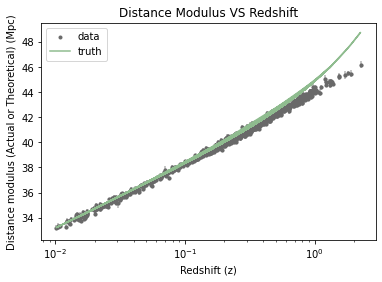

In [94]:
# generate "truth" model

q0_1 = get_q0(0.3, 0.7)
LCDM_1_list = []
for i in range(len(zcmb)):
    LCDM_1 = get_mu_LCDM(70, zcmb[i], q0_1)
    LCDM_1_list.append(LCDM_1)

plt.scatter(zcmb, distance_modulus, label='data', color='dimgray', marker='.', zorder=1)
plt.errorbar(zcmb, distance_modulus, xerr=None, yerr=dmb, fmt='.', ecolor='dimgray', color='dimgray', alpha=0.5)

plt.plot(zcmb, LCDM_1_list, label='truth', color='darkseagreen', zorder=3)

plt.xscale('log')
plt.legend()
plt.title('Distance Modulus VS Redshift')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance modulus (Actual or Theoretical) (Mpc)')
plt.show()

In [96]:
# Least squares fit

pfit, perr = optimize.curve_fit(FlatLambdaCDM, xdata=x, ydata=y, bounds=(0, [70., 1.]))

y_fit_list = []
for i in range(len(zcmb)):
    y_fit = FlatLambdaCDM(H0=pfit[0], Om0=pfit[1])
    y_fit_list.append(y_fit)
    

plt.scatter(zcmb, distance_modulus, label='data', color='dimgray', marker='.', zorder=1)
plt.errorbar(zcmb, distance_modulus, xerr=None, yerr=dmb, fmt='.', ecolor='dimgray', color='dimgray', alpha=0.5)

plt.plot(zcmb, LCDM_1_list, label='truth', color='darkseagreen', zorder=3)

plt.plot(zcmb, y_fit_list, label='curve-fit', color='orange', zorder=4)

plt.xscale('log')
plt.legend()
plt.title('Distance Modulus VS Redshift')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance modulus (Actual or Theoretical) (Mpc)')
plt.show()

print("Estimates:")
print("Omega_M =", pfit[0])
print("Omega_L =", 1 - pfit[0])
print("H0 =", pfit[1])

ValueError: operands could not be broadcast together with shapes (5,) (2,) 

In [98]:
def log_likelihood(theta, x, y, yerr):
    OM, H0 = theta
    OL = 1 - OM
    model =  FlatLambdaCDM(H0=H0, Om0=OM)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [101]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([H0_true, OM_true]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial, args=(x, y, yerr), bounds=((0,70), (0,1)))
H0_ml, OM_ml = soln.x

y_fit_list_2 = []
for i in range(len(zcmb)):
    y_fit =  FlatLambdaCDM(H0=H0_ml, Om0=OM_ml)
    y_fit_list_2.append(y_fit)

print("Maximum likelihood estimates:")
print("OM = {0:.3f}".format(OM_ml))
print("OL = {0:.3f}".format(1 - OM_ml))
print("H0 = {0:.3f}".format(H0_ml))

plt.scatter(zcmb, distance_modulus, label='data', color='dimgray', marker='.', zorder=1)
plt.errorbar(zcmb, distance_modulus, xerr=None, yerr=dmb, fmt='.', ecolor='dimgray', color='dimgray', alpha=0.5)

plt.plot(zcmb, LCDM_1_list, label='truth', color='darkseagreen', zorder=3)

plt.plot(zcmb, y_fit_list, label='curve-fit', color='orange', zorder=4)

plt.plot(zcmb, y_fit_list_2, label='maximum likelihood', color='yellow', zorder=5)

plt.xscale('log')
plt.legend()
plt.title('Distance Modulus VS Redshift')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance modulus (Actual or Theoretical) (Mpc)')
plt.show()

TypeError: unsupported operand type(s) for -: 'FlatLambdaCDM' and 'FlatLambdaCDM'

In [81]:
def log_prior(theta):
    OM, H0 = theta
    if 0.0 < OM < 1.0 and 0.0 < H0 < 70.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [79]:
from emcee import EnsembleSampler
pos = soln.x + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)

sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\payti\anacoda\envs\ASTR 403\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:31<00:00, 161.27it/s]


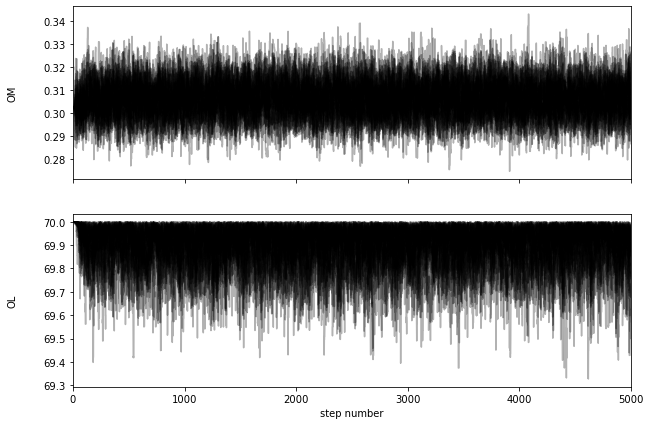

In [84]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["OM", "H0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [85]:
tau = sampler.get_autocorr_time()
print(tau)

[32.12619902 44.94989463]


In [86]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 2)


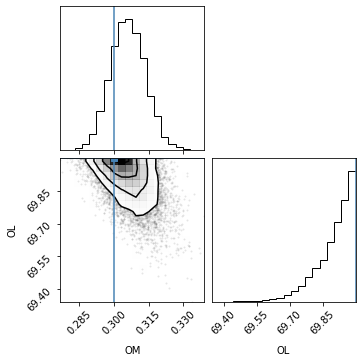

In [87]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[OM_true, H0_true]
);